# Freesound General-Purpose Audio Tagging Challenge

In [1]:
!pip install jovian --upgrade
!pip install librosa --quiet
!pip install opendatasets --upgrade --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install ipython --quiet
import IPython.display as ipd

In [3]:
import jovian

In [4]:
# Execute this to save new versions of the notebook
jovian.commit(project="freesound-general-purpose-audio-tagging-challenge")

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


### Importing the Libraries

In [5]:
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential

In [6]:
%matplotlib inline

In [7]:
print(tf.__version__)

2.9.2


## Loading the Data

In [8]:
dataset_url = 'https://www.kaggle.com/c/freesound-audio-tagging'

In [9]:
od.download(dataset_url)

Skipping, found downloaded files in "./freesound-audio-tagging" (use force=True to force download)


## Audio Classification EDA

In [10]:
filename = '/content/freesound-audio-tagging/audio_test/00063640.wav'

In [11]:
import librosa.display

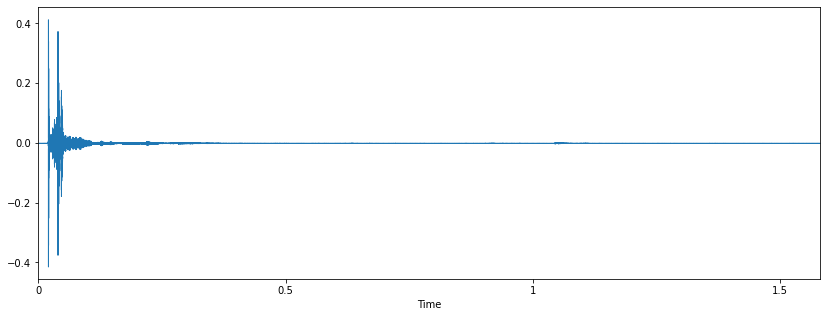

In [12]:
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveplot(data, sr= sample_rate)
ipd.Audio(filename)

In [13]:
sample_rate

22050

In [14]:
data

array([-3.0723128e-05, -2.6443044e-05, -4.6179444e-05, ...,
       -5.7769110e-05,  1.9109632e-06, -2.7519841e-06], dtype=float32)

In [15]:
metadata = pd.read_csv('/content/freesound-audio-tagging/train.csv')

In [16]:
metadata.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [17]:
### Check whether data is imbalance
metadata['label'].value_counts()

Hi-hat                   300
Laughter                 300
Shatter                  300
Applause                 300
Squeak                   300
Acoustic_guitar          300
Bass_drum                300
Saxophone                300
Flute                    300
Double_bass              300
Tearing                  300
Fart                     300
Clarinet                 300
Fireworks                300
Trumpet                  300
Violin_or_fiddle         300
Cello                    300
Snare_drum               300
Oboe                     299
Gong                     292
Knock                    279
Writing                  270
Cough                    243
Bark                     239
Tambourine               221
Burping_or_eructation    210
Cowbell                  191
Harmonica                165
Drawer_open_or_close     158
Meow                     155
Electric_piano           150
Gunshot_or_gunfire       147
Microwave_oven           146
Keys_jangling            139
Telephone     

In [18]:
import os
audio_dataset_path = '/content/freesound-audio-tagging/audio_train'

In [19]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


### Extract Features

We will be using Mel-Frequency Cepstral Coefficients (MFCC) from the audio samples.
The MFCC function processes the entire speech data in a batch. Based on the number of input rows, the window length, and the overlap length, mfcc partitions the speech into 1551 frames and computes the cepstral features for each frame.
These audio representations will allow us to identify features for classification

In [20]:
mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc =40)
print(mfcc.shape)

(40, 69)


In [21]:
mfcc

array([[-1.86636887e+02, -1.13980354e+02, -1.16509644e+02, ...,
        -8.46345886e+02, -8.46602844e+02, -8.51656250e+02],
       [-1.42856712e+01,  1.90730553e+01,  3.95901566e+01, ...,
         1.64430928e+00,  1.65897036e+00,  5.22479594e-01],
       [-7.53735046e+01, -2.85114517e+01,  3.26209855e+00, ...,
         2.35644484e+00,  4.49744433e-01,  2.85588717e+00],
       ...,
       [ 7.73802567e+00,  3.38861489e+00,  7.60310531e-01, ...,
        -4.01352215e+00,  6.10087156e-01,  4.53234959e+00],
       [-9.85304451e+00, -1.09907494e+01, -1.18413696e+01, ...,
        -4.11719561e+00,  1.55436087e+00,  4.51397991e+00],
       [ 7.05399609e+00,  4.19617355e-01, -3.46465540e+00, ...,
         7.01356983e+00,  6.25587940e+00,  4.28914976e+00]], dtype=float32)

Extracting MFCC for every audio file

In [22]:
def features_extracter(file):
  audio, sample_rate = librosa.load(file_name, res_type = 'kaiser_fast')
  mfcc_features = librosa.feature.mfcc(y= audio, sr=sample_rate, n_mfcc =40)
  mfcc_scaled_features = np.mean(mfcc_features.T, axis=0)

  return mfcc_scaled_features


Import relevant libraries

In [23]:
import numpy as np
from tqdm import tqdm

In [24]:
# Now we iterate through every audio filoe and extract features
# using Mel-Frequency Cepstral Coefficients

extracted_features = []

for index_num, row, in tqdm(metadata.iterrows()):
  file_name = os.path.join(os.path.abspath(audio_dataset_path), str(row['fname']))
  final_class_label = row["label"]
  data = features_extracter(file_name)
  extracted_features.append([data, final_class_label])

9473it [22:12,  7.11it/s]


In [25]:
# Converting extracted_features to Pnadas Dataframe

extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.head()

,feature,class
0,"[-427.2885, 18.066782, -50.51572, 5.025327, -2...",Hi-hat
1,"[-337.82224, 89.799255, -61.725796, 14.596454,...",Saxophone
2,"[-623.46454, 104.49299, 2.6089153, 7.3437967, ...",Trumpet
3,"[-764.4792, 8.640426, -6.3671145, -15.080152, ...",Glockenspiel
4,"[-316.50906, 93.676926, -28.949974, 23.692709,...",Cello


In [66]:
# Splitting the dataset into independent and dependent datset

X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [67]:
X.shape

(9473, 40)

In [68]:
y.shape

(9473,)

Import Relevant Libraries

In [69]:
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [70]:
### Label Encoding -> Label Encoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

### Test Train Split

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =0)

In [73]:
X_train.shape[0], X_test.shape[0]

(7578, 1895)

In [74]:
y_train.shape[0], y_test.shape[0]

(7578, 1895)

In [75]:
#No. of Classes
num_labels = y.shape[1]

In [76]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


### Build the Models

1. ANN model using Keras sequential API
2. The first layer has 100 neurons. Input shape is 40 according to the number of features with activation function as Relu, and to avoid any overfitting, we’ll use the Dropout layer at a rate of 0.5.
3. The second layer has 200 neurons with activation function as Relu and the drop out at a rate of 0.5.
5. The third layer again has 100 neurons with activation as Relu and the drop out at a rate of 0.5.

In [77]:
model=Sequential()

# First layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [78]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               4100      
                                                                 
 activation_8 (Activation)   (None, 100)               0         
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 200)               20200     
                                                                 
 activation_9 (Activation)   (None, 200)               0         
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 100)              

In [79]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Training the Model

Import Relavant Libraries


In [80]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='/content/freesound-audio-tagging/audio_train', 
                               verbose=1, save_best_only=True)

start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
236/237 [============================>.] - ETA: 0s - loss: 14.2841 - accuracy: 0.0278
Epoch 1: val_loss improved from inf to 3.70004, saving model to /content/freesound-audio-tagging/audio_train
237/237 [==============================] - 3s 12ms/step - loss: 14.2487 - accuracy: 0.0278 - val_loss: 3.7000 - val_accuracy: 0.0306
Epoch 2/100
233/237 [============================>.] - ETA: 0s - loss: 3.8505 - accuracy: 0.0306
Epoch 2: val_loss improved from 3.70004 to 3.68708, saving model to /content/freesound-audio-tagging/audio_train
237/237 [==============================] - 2s 10ms/step - loss: 3.8492 - accuracy: 0.0305 - val_loss: 3.6871 - val_accuracy: 0.0306
Epoch 3/100
226/237 [===========================>..] - ETA: 0s - loss: 3.7401 - accuracy: 0.0312
Epoch 3: val_loss improved from 3.68708 to 3.67804, saving model to /content/freesound-audio-tagging/audio_train
237/237 [==============================] - 2s 9ms/step - loss: 3.7385 - accuracy: 0.0311 - val_loss: 3.6780 

In [81]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [42]:
#test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
#print(test_accuracy[1])

0.02427440695464611
